# Прогнозирование временных рядов на основе Seq-2-Seq с использованием однонаправленных и двунаправленных LSTM с глубоким стеком в Keras

Ссылка на первоисточник «https://weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/» Вэйминь Ванга.

Этот ноутбук предназначен для реализации архитектуры на основе кодировщика-декодера s2q2seq с использованием сетей LSTM. Одно / многоуровневые однонаправленные и двунаправленные LSTM были опробованы и реализованы на наборе данных одномерного временного ряда «аукциннная цена 1000 кликов».

Основная цель - подчеркнуть эффективность двунаправленных LSTM в изучении сложных шаблонов данных.

In [1]:
import pandas as pd
import numpy as np
import time
from keras.models import model_from_json

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import TensorBoard

from sklearn.preprocessing import MinMaxScaler

## Прочитать данные
Исходный набор данных требует очень небольшой очистки, которую я проделал вручную, поэтому вы можете найти очищенный набор данных в моем репозитории GitHub.

In [2]:
data=pd.read_csv('cl.csv', sep=';', error_bad_lines=False)
data = data.query('Bid < 5000')
data = data.reset_index()


C:\Users\nnig9\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data['Bid'] = data['Bid'].apply(lambda x: float(x))
data['date'] = pd.to_datetime(data['date'])

In [4]:
data[:-10000]

,index,Click_ID,date,banner_type,banner_width,banner_heigth,IP,Device_ID,Bid,OS,OS_Version,Device_mode,Connection_Type,Unnamed: 12
0,0,35803771,2019-09-23 21:46:51,simple,768,1024,91.233.43.235,26D00212-C469-4A3C-824D-8FAD9CA1554C,353.0,iOS,ios 9.3,Apple iPad 1,WiFi,NaN
1,1,35803772,2019-09-23 21:47:17,simple,320,480,5.18.232.72,e51b5d0c-e147-4c7c-a7d9-f54fdbe84918,712.0,Android,android 8,huawei honor 9 lite,None,NaN
2,2,35803773,2019-09-23 21:47:40,simple,320,480,62.33.118.27,5b47abce-0e7c-46c4-97cf-06e8a4746ef2,353.0,Android,android 5.0.2,lenovo a6010,WiFi,NaN
3,3,35803774,2019-09-23 21:49:14,simple,320,480,46.8.244.223,19b84b3c-ddcc-4010-815b-1951f77515bf,353.0,Android,android 4.4,None,WiFi,NaN
4,4,35803775,2019-09-23 21:49:30,simple,320,480,85.93.58.149,b61f2a4d-e008-4526-8654-510c5e4b774f,353.0,Android,android 6.0,micromax q354,WiFi,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387520,1389995,37192376,2020-09-27 04:30:50,simple,320,480,46.249.9.74,b063d92c-85e8-4f50-8555-c7cc5f7d920d,210.0,Android,android 8,huawei dra-lx2,WiFi,NaN
1387521,1389996,37192377,2020-09-27 04:31:37,simple,320,480,178.205.246.6,5c446c19-27f5-4119-bded-96ccb45bcafb,210.0,Android,None,None,WiFi,NaN
1387522,1389997,37192378,2020-09-27 04:32:14,simple,320,480,94.140.143.155,076a935a-4263-4cec-a5da-4dd2091c9fc6,171.0,Android,None,samsung sm-a207f,GPRS/EDGE/3G/LTE,NaN
1387523,1389998,37192379,2020-09-27 04:33:02,simple,320,480,95.153.133.221,6f2d8c62-4d62-4136-bae3-5a8121be4a5d,171.0,Android,android 8,xiaomi redmi 6a,GPRS/EDGE/3G/LTE,NaN


###### series = data['Bid'][:].reset_index()

series = data['Bid'][-3000:].reset_index()
series = series.drop('index',axis=1)

In [6]:
#series

In [7]:
seq = series.copy()
scaler = MinMaxScaler(feature_range=(-1,1))
X =scaler.fit_transform(seq.values.reshape(-1,1))
#seq = np.log(seq.values)

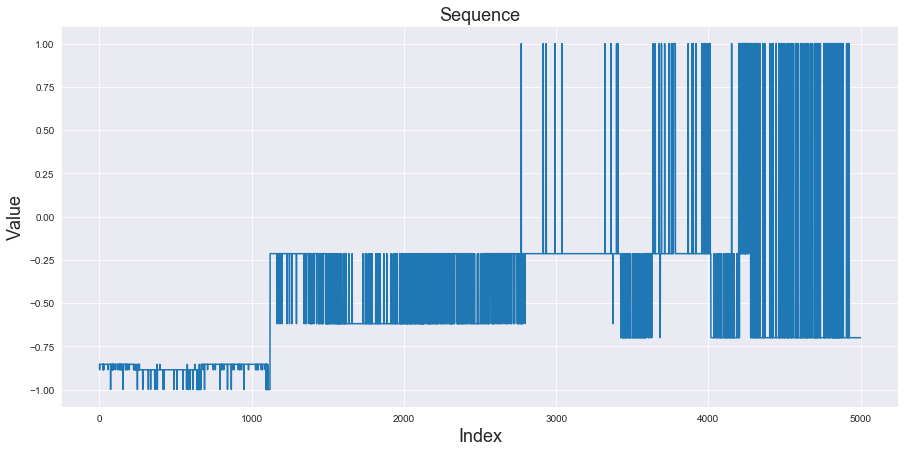

In [8]:
series = X
seq = series.copy()
seqq = series[-1000:].copy()
plt.figure(figsize=(15,7))
plt.title("Sequence", fontsize = 18)
plt.xlabel("Index", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.plot(seq[:])
plt.show()

In [9]:
#scaler = MinMaxScaler(feature_range=(-1,1))
#X =scaler.fit_transform(seq.values.reshape(-1,1))

In [10]:
#X[:100]

In [11]:
#data['Bid']
# plt.plot(X[:100])
# plt.plot(np.log(data['Bid'][:200]))

In [12]:
#1397525
x_train = X[:-400]
x_test = X[-400:]

In [13]:
x_train

array([[-0.85425101],
       [-0.88582996],
       [-0.85425101],
       ...,
       [-0.70040486],
       [-0.70040486],
       [-0.70040486]])

**Обратите внимание**, что в приведенных выше ячейках мы не делали никаких изменений в серии, чтобы преобразовать ее в модель обучения с учителем. Вскоре вы увидите причину, по которой мы этого не сделали.

В ячейке ниже определяется длина входной и выходной последовательности. Мы также определяем номера входных характеристик (столбцов) мы даем модели, а номер ожидаемых выходных характеристик (столбцов). В случае многомерных данных нет.номера входных функций будет> 1 в зависимости от того, сколько вы включаете в модель.

In [14]:
input_seq_len = 60
output_seq_len = 20
n_in_features = 1
n_out_features = 1
batch_size = 10
batch_size

10

### Помощник для создания тренировочных пакетов.
Всего "input_seq_len + Output_seq_len" нет. точек будет формировать единую обучающую выборку, где наши входы (X) (входы кодировщика) будут «input_seq», а наши цели (Y) (цели декодера) будут «output_seq». По этой причине мы не сместили последовательность на один шаг при генерации разбиений на тренировка-тест. <br/>
Здесь мы выбираем случайные индексы и создаем такие выборки, чтобы сформировать пакет размером = batch_size.

In [15]:
def generate_train_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

In [16]:
#generate_train_sequences(X)

## Построить архитектуру модели

In [17]:
def create_model(layers, bidirectional = False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape = (None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    
    if bidirectional:
        
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        
        for i in range(int(len(bi_encoder_states) / 2)):
            
            temp = []
            for j in range(2):
                
                temp.append(concatenate([bi_encoder_states[i][j], bi_encoder_states[n_layers + i][j]], axis = -1))
                
            encoder_states.append(temp)
    else:  
        
        encoder = RNN(lstm_cells, return_state = True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape = (None, n_out_features))
    
    if bidirectional:
        
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences = True, return_state=True)
    decoder_outputs_and_states = decoder_lstm(decoder_inputs, initial_state = encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]
    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

**Обратите внимание**, что если выбрана двунаправленность, тогда длина ячеек декодера будет вдвое больше, чем у кодера, поскольку мы объединяем прямое и обратное состояния кодера.

## Запускаем model.fit

In [18]:
callbacks = [TensorBoard(log_dir='tb_logs_s2s', histogram_freq=1, write_images=True)]

In [19]:
def run_model(model,batches,epochs,batch_size):
    global history
    for _ in range(batches):

        input_seq, output_seq = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1, 
                             shuffle=False,
                             callbacks=callbacks)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [20]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

# 1 Однонаправленный 1-слойный

In [22]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('model_1.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model_1 = model_from_json(loaded_model_json)
# # load weights into new model
# model_1.load_weights("model_1.h5")
# print("Loaded model from disk")

**Обратите внимание**, что аргумент Layers должен быть списком latent_dims в каждом слое. Пример для 2 слоев по 40 димов в каждом ==> [40,40].

In [23]:
total_loss = []
total_val_loss = []
model_1.compile(Adam(), loss = 'mean_squared_error')

In [24]:
start_time = time.time()
run_model(model_1,batches=1, epochs=100, batch_size=batch_size)
end_time = time.time()

Epoch 1/100
  1/407 [..............................] - ETA: 0s - loss: 0.5011WARNING:tensorflow:From C:\Users\nnig9\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
407/407 [==============================] - 7s 18ms/step - loss: 0.0769 - val_loss: 0.0646
Epoch 2/100
407/407 [==============================] - 7s 17ms/step - loss: 0.0716 - val_loss: 0.0643
Epoch 3/100
407/407 [==============================] - 7s 17ms/step - loss: 0.0717 - val_loss: 0.0643
Epoch 4/100
407/407 [==============================] - 7s 17ms/step - loss: 0.0711 - val_loss: 0.0642
Epoch 5/100
407/407 [==============================] - 7s 17ms/step - loss: 0.0706 - val_loss: 0.0643
Epoch 6/100
407/407 [==============================] - 7s 17ms/step - loss: 0.0702 - val_loss: 0.0641
Epoch 7/100
407/407 [====================

KeyboardInterrupt: 

In [ ]:
#history.history['loss']

In [ ]:
run_time = (end_time - start_time)/60
run_time

In [ ]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [ ]:
history.historyn.keys()

In [ ]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)

    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

In [ ]:
plot_loss(total_loss,total_val_loss)

In [ ]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = x_test[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

In [ ]:
input_seq_test

In [ ]:
pred1 = model_1.predict([input_seq_test,decoder_input_test])

In [ ]:
pred_values1 = scaler.inverse_transform(pred1.reshape(-1,1))
output_seq_test1 = scaler.inverse_transform(output_seq_test)

In [ ]:
plt.plot(pred_values1, label = "pred")
plt.plot(output_seq_test1, label = "actual")
plt.title("1-напр 1-слойный")
plt.ylabel("Bid", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.legend()
plt.savefig('uni_dir1.png')

In [ ]:
# serialize model to JSON
# model_json = model_1.to_json()
# with open("model_1.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model_1.save_weights("model_1.h5")
# print("Saved model to disk")

# 2 Двунаправленный 1-слойный

In [ ]:
model1_bi = create_model(layers=[60],bidirectional=True)

In [ ]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('model1_bi.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model1_bi = model_from_json(loaded_model_json)
# # load weights into new model
# model1_bi.load_weights("model1_bi.h5")
# print("Loaded model from disk")

In [ ]:
total_loss = []
total_val_loss = []
model1_bi.compile(Adam(), loss = 'mean_squared_error')

In [ ]:
#bi 1 layered model
start_time = time.time()
run_model(model1_bi,batches=1, epochs=100, batch_size=batch_size)
end_time = time.time()

In [ ]:
run_time = (end_time - start_time)/60
run_time

In [ ]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [ ]:
plot_loss(total_loss,total_val_loss)

In [ ]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = x_test[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

In [ ]:
pred = model1_bi.predict([input_seq_test,decoder_input_test])

In [ ]:
pred_values = scaler.inverse_transform(pred.reshape(-1,1))
output_seq_test = scaler.inverse_transform(output_seq_test)
input_seq_test = scaler.inverse_transform(input_seq_test.reshape(-1,1))

In [ ]:
plt.plot(pred_values, label = "pred")
plt.plot(output_seq_test, label = "actual")
plt.title("2-напр 1-слойный")
plt.ylabel("Bid", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.legend()
plt.savefig('bi_dir1.png')

In [ ]:
# serialize model to JSON
# model_json = model_1.to_json()
# with open("model1_bi.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model_1.save_weights("model1_bi.h5")
# print("Saved model to disk")

# 3 Однонаправленный 2-слойный

In [ ]:
model_2 = create_model([60,60],bidirectional=False)

In [ ]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('model_2.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model_2 = model_from_json(loaded_model_json)
# # load weights into new model
# model_2.load_weights("model_2.h5")
# print("Loaded model from disk")

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_2 = model_from_json(loaded_model_json)
# load weights into new model
model_2.load_weights("model_2.h5")
print("Loaded model from disk")

In [ ]:
total_loss = []
total_val_loss = []
model_2.compile(Adam(), loss = 'mean_squared_error')

In [ ]:
start_time = time.time()
run_model(model_2,batches=1, epochs=100, batch_size=batch_size)
end_time = time.time()

In [ ]:
run_time = (end_time - start_time)/60
run_time

In [ ]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [ ]:
plot_loss(total_loss,total_val_loss)

In [ ]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = x_test[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

In [ ]:
pred2 = model_2.predict([input_seq_test,decoder_input_test])

In [ ]:
pred_values2 = scaler.inverse_transform(pred2.reshape(-1,1))
output_seq_test2 = scaler.inverse_transform(output_seq_test)

In [ ]:
plt.plot(pred_values2, label = "pred")
plt.plot(output_seq_test2, label = "actual")
plt.title("1-напр 1-слойн")
plt.ylabel("Bid", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.legend()
plt.savefig('uni_dir2.png')

In [ ]:
# # serialize model to JSON
# model_json = model_2.to_json()
# with open("model_2.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model_2.save_weights("model_2.h5")
# print("Saved model to disk")

# 4 Двунаправленный 2-слойный

In [ ]:
model2_bi = create_model([60,60],bidirectional=True)

In [ ]:
# загрузка джейсона
from keras.models import model_from_json

# json_file = open('model2_bi.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model2_bi = model_from_json(loaded_model_json)
# # load weights into new model
# model2_bi.load_weights("model2_bi.h5")
# print("Loaded model from disk")

In [ ]:
total_loss = []
total_val_loss = []
model2_bi.compile(Adam(), loss = 'mean_squared_error')

In [ ]:
start_time = time.time()
run_model(model2_bi,batches=1, epochs=10, batch_size=batch_size)
end_time = time.time()

In [ ]:
run_time = (end_time - start_time)/60
run_time

In [ ]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

In [ ]:
plot_loss(total_loss,total_val_loss)
plt.savefig('bi_los2.png')

In [ ]:
input_seq_test = x_train[-60:].reshape((1,60,1))
output_seq_test = x_test[:20]
decoder_input_test = np.zeros((1,output_seq_len,1))

In [ ]:
pred2_bi = model2_bi.predict([input_seq_test,decoder_input_test])

In [ ]:
pred_values2_bi = scaler.inverse_transform(pred2_bi.reshape(-1,1))
output_seq_test2_bi = scaler.inverse_transform(output_seq_test)

In [ ]:
pred2_bi = model2_bi.predict([input_seq_test,decoder_input_test])

In [ ]:
plt.plot(pred_values2_bi, label = "pred")
plt.plot(output_seq_test2_bi, label = "actual")
plt.title("2-напр 2-слойн")
plt.ylabel("Bid", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.legend()
plt.savefig('bi_dir2.png')

In [ ]:
# serialize model to JSON
# model_json = model2_bi.to_json()
# with open("model2_bi.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model2_bi.save_weights("model2_bi.h5")
# print("Saved model to disk")

# Прогнозирование на основе скользящего среднего

In [ ]:
series = data['Bid']
series=np.log(series.)

In [ ]:
def moving_average(series, n):
    """
        Вычислить среднее за последние n наблюдений
        Calculate average of last n observations
    """
    return np.average(series[-n:])


a=scaler.inverse_transform(moving_average(X, 500000).reshape(-1,1))
a

In [ ]:
#893.16-